# Investigation into Fandango's Movie Ratings Inflation

In October 2015, after the [analytical work](https://fivethirtyeight.com/features/fandango-movies-ratings/) of data journalist Walt Hickey, it came to light that Fandango's rating systems were not accurately reflecting the actual ratings of movies. 

Fandango's officials replied that this was due to a bug that caused ratings to be rounded up, but we cannot verify this because the actual rating values don't appear to be displayed in the HTML of the pages.

The objective of this project will therefore be to analyze data from the ratings of more recent movies, to determine whether Fandango properly fixed its rating system since Walt Hickey's analysis.

The datasets we'll be using are:

- Walt Hickey's [collected data](https://github.com/fivethirtyeight/data/tree/master/fandango) from before Fandango's ratings inflation became public, which is publicly available on GitHub
- [Movie Ratings](https://github.com/mircealex/Movie_ratings_2016_17) for movies released in 2016 and 2017, after Walt Hickey made his findings public

## Reading in the Datasets

We'll begin by reading in and then briefly exploring the two datasets, `fandango_score_comparison.csv` and `movie_ratings_16_17.csv`.

In [2]:
import numpy as np
import pandas as pd

fandango_score = pd.read_csv('fandango_score_comparison.csv')
score_16_17 = pd.read_csv('movie_ratings_16_17.csv')

In [3]:
fandango_score.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [4]:
score_16_17.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


We'll proceed to isolate the columns that provide info on Fandango's ratings.

In [5]:
before = fandango_score[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']]

after = score_16_17[['movie', 'year', 'fandango']]

In [8]:
before.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [9]:
after.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


## The Initial Objective

Since we're trying to determine whether Fandango's rating system was changed after Walt Hickey's analysis, the population we're going to be interested in durig this project are the movie ratings stored on Fandango's website, regardless of their release year. 

We're going to be sampling the population at two different periods of time, namely before and after Walt Hickey's analysis. This is why we're using two datasets acquired at those two different periods of time. 

We also need to ensure that our data is *representative*, since we're trying to make a description of the entire population, otherwise we'd have significant sampling error, and pointless results. 

## Sampling Criteria

From the GitHub repo containing Hickey's findings, we see that Hickey used the following criteria in his sampling:

1. The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015)
2. The movie must have had tickets on sale in 2015
 
This shows that the sampling wasn't random, as movies that didn't meet the above criteria had no chance to be picked. It might be the case that this sample therefore isn't entirely representative of the entire population we're trying to describe.

For the dataset containing ratings from 2016 and 2017, we see that these were the sampling criteria:

1. The movie must have been released in 2016 or later.
2. The movie must have had a considerable number of votes and reviews (it's not clear how many from the README.md or from the data).

It is also likely that this second set isn't representative of the whole population.

**Both of these analysts had objectives in mind when they sampled their data, and so they used criteria to get samples that would meet their objectives.**

Their sampling method is called purposive sampling (or judgmental/selective/subjective sampling). While these samples were adequate for their research, they don't seem too useful for us.

## Revised Objective

In light of the above limitations, we'll revise our objective somewhat:
Instead of attempting to describe the population of all the movies, we're now only going to describe the **movies that were popular in 2015 and 2016.**

We'll define popularity as having at least 30 Fan ratings, since this was the standard Walt Hickey used.

## Verifying that datasets meet sampling criteria

### 1) Criteria 1 - Popularity (more than 30 Fan Ratings)

Since the 2nd dataset doesn't contain info on the number of ratings, we'll randomly sample 10 movies from it, and then verify the number of fan ratings ourselves on Fandango's site.

In [12]:
after.sample(10, random_state=2)

,movie,year,fandango
23,Bitter Harvest,2017,4.5
155,Table 19,2017,3.0
207,Whiskey Tango Foxtrot,2016,3.5
13,Arsenal,2017,3.5
64,Gold,2016,3.5
131,Pele: Birth of a Legened,2016,4.5
141,Sausage Party,2016,3.5
193,The Secret Life of Pets,2016,4.0
93,Kung Fu Panda 3,2016,4.5
30,Cafe Society,2016,3.5


After verifying that all the 10 movies above had at least 30 fan ratings, we can proceed with a bit more confidence that the movies from the second dataset can be regarded as popular.

We'll also quickly double-check that there were no movies with less than 30 fan-ratings in the `before` dataframe.

In [19]:
(before['Fandango_votes'] < 30).sum()

0

### Criteria 2 - Year

**Since we're only looking at movies that came out in 2015 or 2016**, we should check that the `before` and `after` dataframes contain only movies from these years.

In [22]:
before.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In the `before` dataframe, we see that the year of the movie is listed together with its name. We'll make a new column containing only the isolated year.

In [29]:
before2 = before.copy()

before2['year'] = before2['FILM'].str[-5:-1]

before2.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015


In [30]:
before2.year.value_counts()

2015    129
2014     17
Name: year, dtype: int64

We see that there are some movies from 2014. We'll exclude these. 

In [31]:
before2 = before2[before2['year'] == '2015']

before2.year.value_counts()

2015    129
Name: year, dtype: int64

We'll repeat the same process for the `after` dataset.

In [33]:
after.year.value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [37]:
after2 = after[after['year'] == 2016]

after2.year.value_counts()

2016    191
Name: year, dtype: int64

We've now distilled the datasets further into two variables, `before2` and `after2` that meet the sampling criteria we outlined. We'll use these two with the rest of our analysis.

## Comparison of datasets

To once gain reiterate our objective, **our aim is to find out if there's any difference between Fandango's ratings for popular movies in 2015, and their ratings for popular movies in 2016.**

We'll begin by making graphs that let us have an overview of the total picture. 

### Kernel Density Estimates

First, we'll start with kernel density plots for the distribution of movie ratings for both datasets.

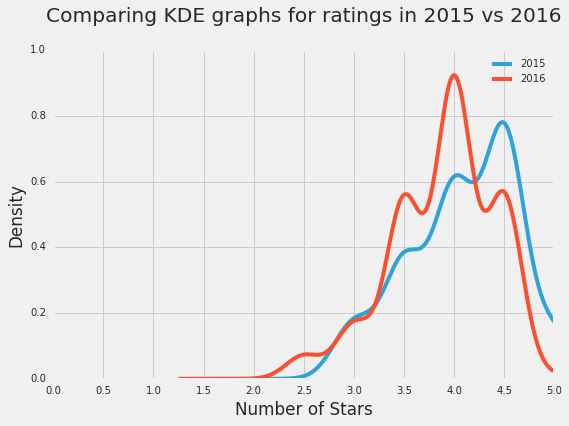

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

before2['Fandango_Stars'].plot(kind='kde', label ='2015', legend = True, figsize = (8,5.5) )
after2['fandango'].plot.kde(label = '2016', legend = True)

plt.title("Comparing KDE graphs for ratings in 2015 vs 2016",
          y = 1.07)
plt.xlabel('Number of Stars')
plt.xlim(0,5)
plt.xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])

plt.show()

We observe the following:

- Both graphs are left-skewed. It appears that almost no movies got below 2 stars. Fandango in general has a tendency to rate movies quite highly on average.

- The 2016 distribution much more closely resembles a normal distribution that the ratings from 2015. 

- The ratings from 2016 seem to be a bit lower on average. 

So far, it looks like the ratings from 2016 were indeed a bit lower, but we'll look closer at more detail information about the ratings.

### Comparing Rating Frequencies

We'll compare the relative frequencies of each kind of rating from both years.

In [49]:
print('2015' + '\n' + '-' * 16)

before2['Fandango_Stars'].value_counts(normalize=True).sort_index() * 100

2015
----------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [50]:
print('2016' + '\n' + '-' * 16)

after2['fandango'].value_counts(normalize=True).sort_index() * 100

2016
----------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

This helps us spot a couple of very key things:

- In 2015, a lot of movies were rating 5.0 stars - about 7% of them. In 2016 however, only around 0.5% of movies were rated 5.0 stars.

- In 2015, there were no movies rated 2.5 stars or less, whereas there are movies with this rating in 2016. 

- In 2016, there is a very large representation of movies with 4.0 star ratings. In 2015, the most common rating is in fact 4.5 stars.

### Confirming the Direction of Change

We'll compare the mean, median, and mode of both datasets directly, and then plot the data to viualize whether there's any discernible conclusions that can be made about the direction of change from them.

In [55]:
mean_2015 = before2['Fandango_Stars'].mean()
median_2015 = before2['Fandango_Stars'].median()
mode_2015 = before2['Fandango_Stars'].mode()[0]

mean_2016 = after2['fandango'].mean()
median_2016 = after2['fandango'].median()
mode_2016 = after2['fandango'].mode()[0]

We'll build a dataframe in which to assign the above variables.

In [57]:
comparison = pd.DataFrame()

comparison['2015'] = [mean_2015, median_2015, mode_2015]
comparison['2016'] = [mean_2016, median_2016, mode_2016]

comparison

,2015,2016
0,4.085271,3.887435
1,4.000000,4.000000
2,4.500000,4.000000


We'll change the index to reflect whether the value was a mean, median, or mode.

In [60]:
comparison.index = ['mean', 'median', 'mode']

comparison

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


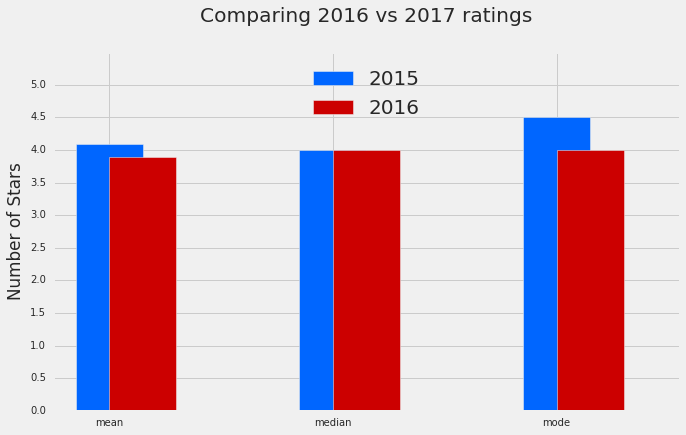

In [73]:
comparison['2015'].plot.bar(color = '#0066FF', align = 'center', label = '2015', width = .3)
comparison['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', width = .3,
                         rot = 0, figsize = (10,6))

plt.title('Comparing 2016 vs 2017 ratings', y = 1.07)
plt.ylim(0,5.5)
plt.yticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])

plt.ylabel('Number of Stars')
plt.legend(framealpha = 0, loc = 'upper center', prop={'size': 20})

plt.show()

## Conclusion

While both years have the same median rating, that is not necessarily conclusive of anything on its own given that there were only 6-7 or so different rating values, between 2.5 to 5.0.

The mean rating of movies in 2016 fell by 0.2, which is a significant difference. Additionally, the most common rating in 2016 was 4.0, and not 4.5 as was observed the previous year.

It stands to reason that the cause for these differences was probably the fix to their rating system that Fandango applied.